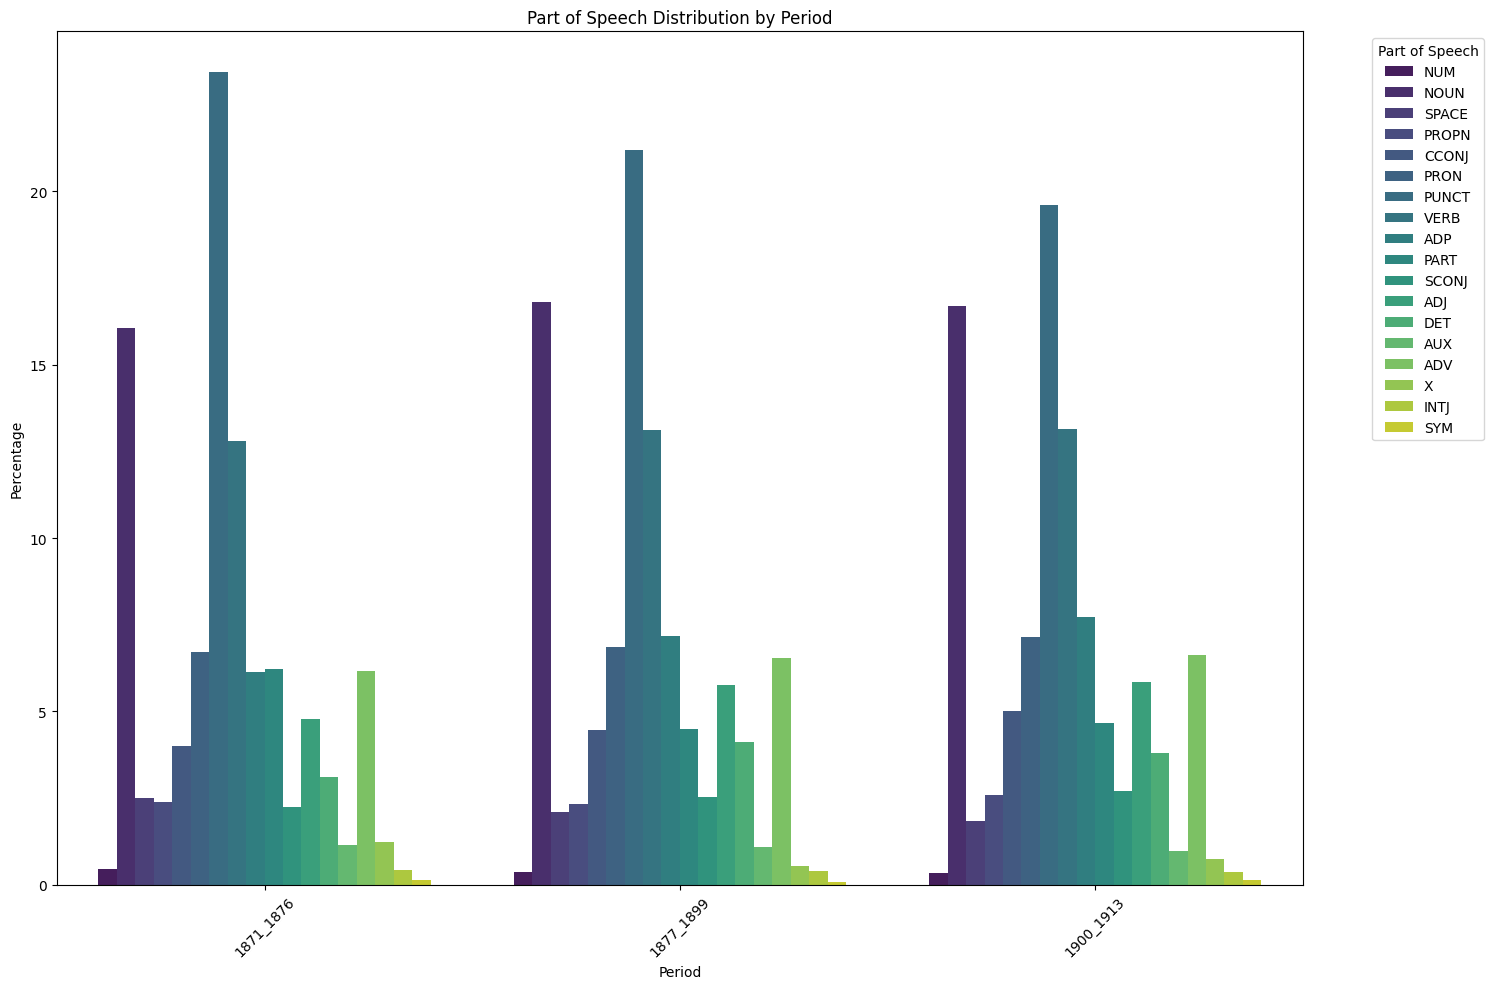

C:\Users\Lesia\AppData\Local\Temp\ipykernel_2872\3597145280.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=word_df, x='Genre', y='Length', palette='Set3')


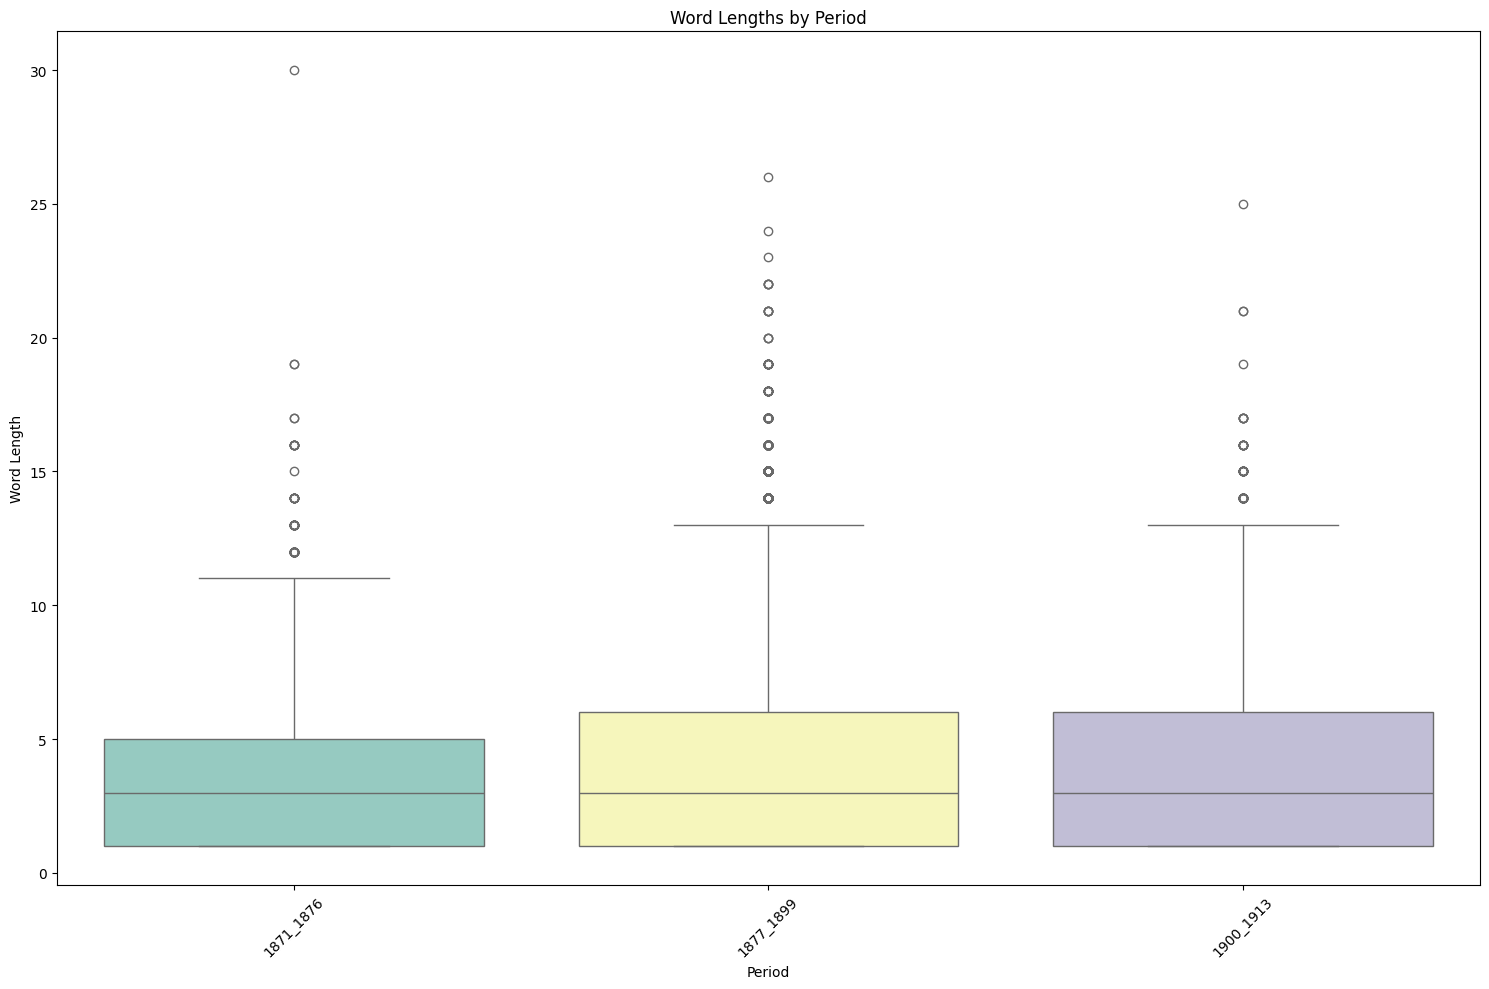

C:\Users\Lesia\AppData\Local\Temp\ipykernel_2872\3597145280.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sent_df, x='Genre', y='Length', palette='Set2')


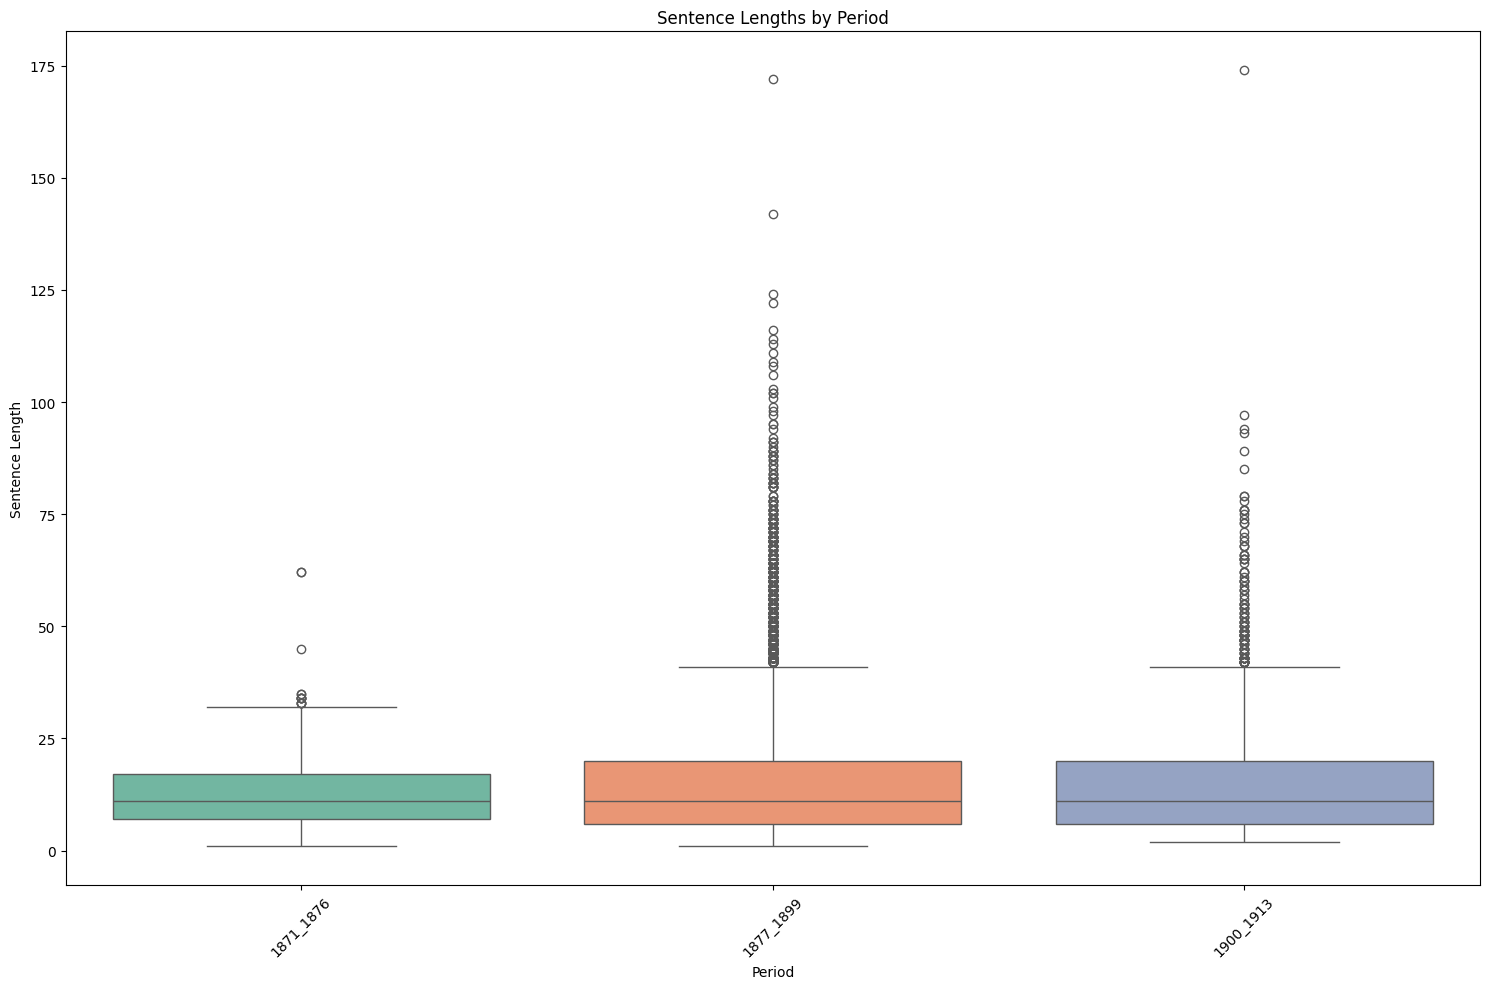

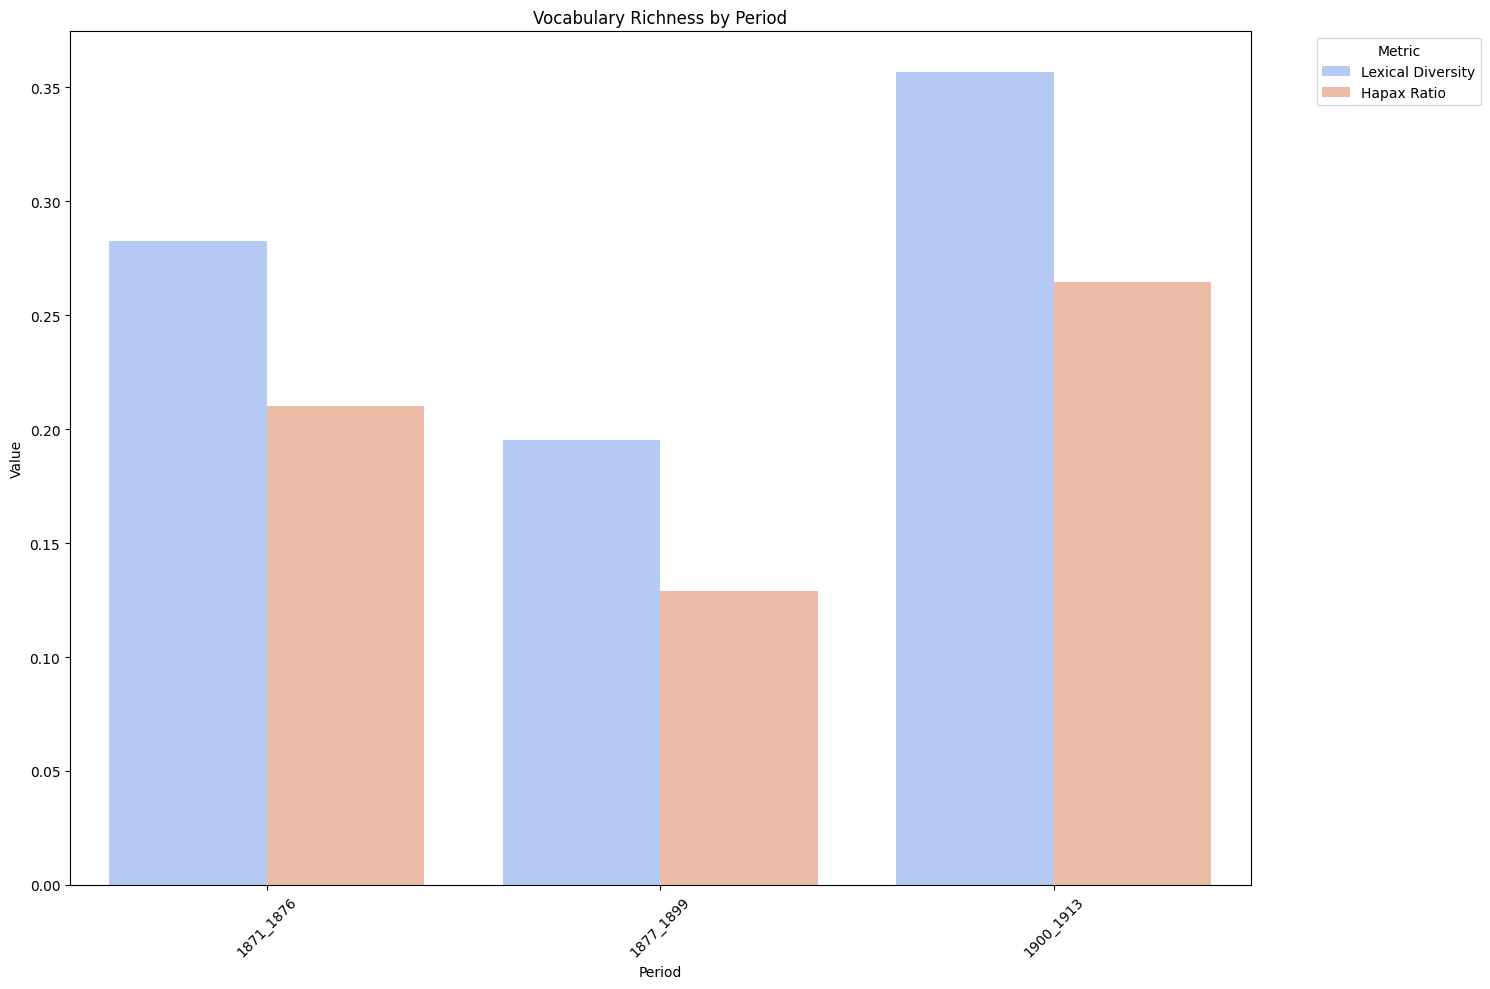

In [5]:
import os
import glob
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from readability.readability import Readability

# loading the language to work with (uk -Ukrainian)
nlp = spacy.load('uk_core_news_sm')

def analyze_text(text):
    """Analyze a single text and return various linguistic metrics."""
    # tokenize
    sentences = sent_tokenize(text)
    words = word_tokenize(text)
    
    num_sentences = len(sentences)
    num_words = len(words)
    avg_sentence_length = num_words / num_sentences if num_sentences > 0 else 0
    
    unique_words = len(set(words))
    lexical_diversity = unique_words / num_words if num_words > 0 else 0
    hapax_ratio = len([word for word, count in Counter(words).items() if count == 1]) / num_words if num_words > 0 else 0
    
    r = Readability(text)
    flesch_score = r.flesch_kincaid().score if num_words > 10 else None
    
    doc = nlp(text)
    pos_counts = Counter([token.pos_ for token in doc])
    total_pos = sum(pos_counts.values())
    pos_distribution = {pos: count for pos, count in pos_counts.items()}
    
    return {
        'num_sentences': num_sentences,
        'num_words': num_words,
        'avg_sentence_length': avg_sentence_length,
        'lexical_diversity': lexical_diversity,
        'hapax_ratio': hapax_ratio,
        'flesch_score': flesch_score,
        'pos_distribution': pos_distribution,
        'word_lengths': [len(word) for word in words],
        'sentence_lengths': [len(word_tokenize(sent)) for sent in sentences]
    }

def process_directory(directory):
    results = []
    for filepath in glob.glob(os.path.join(directory, '*.txt')):
        with open(filepath, 'r', encoding='utf-8') as file:
            text = file.read()
            results.append(analyze_text(text))
    return results

def analyze_period(base_directory):
    all_results = []
    periods = []
    
    for dir in os.listdir(base_directory):
        full_path = os.path.join(base_directory, dir)
        if os.path.isdir(full_path):
            genre_results = process_directory(full_path)
            if genre_results:
                all_results.append(genre_results)
                periods.append(dir)
    
    return all_results, periods

def visualize_results(all_results, genres):
    """Create visualizations for all metrics."""
    if not all_results or not genres:
        print("No data available for visualization")
        return

    # part of speech (POS) distribution
    pos_data = []
    for period_idx, genre_results in enumerate(all_results):
        genre = genres[period_idx]
        genre_pos = Counter()
        
        for result in genre_results:
            genre_pos.update(result['pos_distribution'])
            
        total = sum(genre_pos.values())
        if total > 0:
            for pos, count in genre_pos.items():
                pos_data.append({
                    'Genre': genre,
                    'POS': pos,
                    'Percentage': (count / total) * 100
                })
    
    if pos_data:
        pos_df = pd.DataFrame(pos_data)

        plt.figure(figsize=(15, 10))
        sns.barplot(data=pos_df, x='Genre', y='Percentage', hue='POS', palette='viridis')
        plt.title('Part of Speech Distribution by Period')
        plt.xlabel('Period')
        plt.ylabel('Percentage')
        plt.xticks(rotation=45)
        plt.legend(title='Part of Speech', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    # word lengths graph
    word_data = []
    for genre_idx, genre_results in enumerate(all_results):
        genre = genres[genre_idx]
        for result in genre_results:
            for length in result['word_lengths']:
                word_data.append({
                    'Genre': genre,
                    'Length': length
                })
    
    if word_data:
        word_df = pd.DataFrame(word_data)
        plt.figure(figsize=(15, 10))
        sns.boxplot(data=word_df, x='Genre', y='Length', palette='Set3')
        plt.title('Word Lengths by Period')
        plt.xlabel('Period')
        plt.ylabel('Word Length')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # sentence lengths plot
    sent_data = []
    for genre_idx, genre_results in enumerate(all_results):
        genre = genres[genre_idx]
        for result in genre_results:
            for length in result['sentence_lengths']:
                sent_data.append({
                    'Genre': genre,
                    'Length': length
                })
    
    if sent_data:
        sent_df = pd.DataFrame(sent_data)
        plt.figure(figsize=(15, 10))
        sns.boxplot(data=sent_df, x='Genre', y='Length', palette='Set2')
        plt.title('Sentence Lengths by Period')
        plt.xlabel('Period')
        plt.ylabel('Sentence Length')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    #  vocabulary richness 
    rich_data = []
    for genre_idx, genre_results in enumerate(all_results):
        genre = genres[genre_idx]
        avg_lex_div = sum(r['lexical_diversity'] for r in genre_results) / len(genre_results)
        avg_hapax = sum(r['hapax_ratio'] for r in genre_results) / len(genre_results)
        rich_data.append({
            'Genre': genre,
            'Lexical Diversity': avg_lex_div,
            'Hapax Ratio': avg_hapax
        })
    
    if rich_data:
        rich_df = pd.DataFrame(rich_data)
        rich_df_melted = pd.melt(
            rich_df,
            id_vars=['Genre'],
            value_vars=['Lexical Diversity', 'Hapax Ratio'],
            var_name='Metric',
            value_name='Value'
        )
        
        plt.figure(figsize=(15, 10))
        sns.barplot(data=rich_df_melted, x='Genre', y='Value', hue='Metric', palette='coolwarm')
        plt.title('Vocabulary Richness by Period')
        plt.xlabel('Period')
        plt.ylabel('Value')
        plt.xticks(rotation=45)
        plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

def main():
    # path with files
    base_directory = 'data_franko'
    results, genres = analyze_period(base_directory)
    visualize_results(results, genres)

if __name__ == "__main__":
    main()